# Kalman Criteria Optimization

In [1]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compute_observability_matrix(A, C):
    """
    Computes the observability matrix for a given A and C.
    """
    n = A.shape[0]
    O = C
    A_powers = np.eye(n)
    
    for i in range(1, n):
        A_powers = A @ A_powers
        O = np.vstack([O, C @ A_powers])
        
    return O

def score_observability(O):
    """
    Scores the observability matrix based on its rank.
    """
    rank = np.linalg.matrix_rank(O)
    return rank

def generate_random_sparse_matrix(n, sparsity):
    """
    Generates a random sparse matrix of size n x n with a given sparsity level.
    """
    # The sparsity level should be between 0 and 1
    if not (0 <= sparsity <= 1):
        raise ValueError("Sparsity must be between 0 and 1.")
    
    # Generate a dense random matrix first
    dense_matrix = np.random.rand(n, n)
    
    # Apply sparsity by zeroing out a fraction of the entries
    mask = np.random.rand(n, n) > sparsity
    sparse_matrix = dense_matrix * mask
    
    return sparse_matrix

def generate_random_binary_C(p, n):
    """
    Generates a binary matrix C of size p x n where each row contains a single one and the rest are zeros.
    """
    if p > n:
        raise ValueError("Number of rows (p) cannot be greater than number of columns (n).")
    
    C = np.zeros((p, n), dtype=int)
    idxs = np.random.choice(n, size=p, replace=False)
    for i in range(p):
        C[i, idxs[i]] = 1
    return C

def generate_brad_C(n, idxs):
    """
    Generates a binary matrix C of size p x n where each row contains a single one and the rest are zeros.
    """
    p = len(idxs)
    C = np.zeros((p, n), dtype=int)
    for i in range(p):
        C[i, idxs[i]] = 1
    return C

## Random Trials

In [7]:
# Define the system matrix A
n = 10
p = 3
sparsity = 0.9
A = generate_random_sparse_matrix(n, sparsity)

# Parameters for iteration
num_iterations = 10000
best_C = None
best_score = 0

for ii in range(num_iterations):
    # Guess matrix C
    C = generate_random_binary_C(p, n)
    
    # Compute observability matrix
    O = compute_observability_matrix(A, C)
    
    # Score the observability
    score = score_observability(O)
    
    # print(f"Matrix C:\n{C}\nObservability Matrix:\n{O}\nScore: {score}\n")
    
    # Update the best C if current score is higher
    if score > best_score:
        best_score = score
        best_C = C
    if score == n:
        print(f"{ii=}")
        break

print(f"Best Matrix C:\n{best_C}\nBest Score: {best_score}")

ii=8
Best Matrix C:
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0]]
Best Score: 10


## BRAD Guessing

In [2]:
from BRAD import brad

In [23]:
def responseParser(response):
    nums = response.split('=')[1].split('\n')[0].strip().split(',')
    for i in range(len(nums)):
        nums[i] = int(nums[i].strip().replace('[','').replace(']',''))
    return nums
responseParser(response)

[5, 0]

### Automatic

In [47]:
bot = brad.chatbot(interactive=False, config='/home/jpic/RAG-DEV/tutorials/control/config-no-debug.json')

2024-08-01 03:26:56 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-08-01_03-26-56/log.json. How can I help?


In [67]:
n

25

In [68]:
history = ""
first_template = """You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size {n} by {n}. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the ith column of C. You may select {p} state
variables, numbered 0, 1, ..., {n}-1 to measure.

Based on the sensors you select, the rank of the Kalman observability matrix will be provided for the set of
sensors you select. We will then try a new set of sensors until the rank of the Kalman matrix is n.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
"""

second_template = """You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size {n} by {n}. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the ith column of C. You may select {p} state
variables, numbered 0, 1, ..., {n}-1 to measure.

Based on the sensors you select, the rank of the Kalman observability matrix will be provided for the set of
sensors you select. We will then try a new set of sensors until the rank of the Kalman matrix is n.

Based on your previous proposals, we have the following results:
{history}

**Do not repeat an identical guess that has been used before**

Given this information, please propose new sensors to maximize the Kalman Rank.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
Reasoning=<explain what in the history motivated testing this combination of sensors. 3 Sentences only>
"""

filled_template = first_template.format(n=n, p=p)
response = bot.invoke(filled_template)
score = 0
guesses = []
scores  = []
while score < n:
    idxs = responseParser(response)
    guesses.append(idxs)
    C = generate_brad_C(n, idxs)
    O = compute_observability_matrix(A, C)
    score = score_observability(O)
    scores.append(score)
    print("*********************")
    print(f"{score=}")
    print("*********************")
    if score == n:
        break
    
    history += f'\nSensors={idxs}, Kalman Rank={score}'
    
    filled_template = second_template.format(idxs=str(idxs), score=score, p=p, history=history, n=n)
    response = bot.invoke(filled_template)
    if len(scores) > 25:
        break
    

2024-08-01 03:36:24,714 - INFO - RAG


BRAD >> 31: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:36:25,132 - INFO - 


route



2024-08-01 03:36:25,133 - INFO - RAG
2024-08-01 03:36:25,133 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=0, 12, 23
*********************
score=16
*********************


2024-08-01 03:36:25,784 - INFO - RAG


BRAD >> 32: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:36:27,361 - INFO - 


route



2024-08-01 03:36:27,361 - INFO - RAG
2024-08-01 03:36:27,361 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=1, 7, 18
Reasoning=The previous attempt Sensors=[0, 12, 23] reached a rank of 16, suggesting that the sensors are close to covering the observable space. I'm proposing a new set of sensors that are relatively far apart in the matrix A to increase the chances of covering more of the observable space. By selecting sensors 1, 7, and 18, I'm hoping to fill in the gaps and reach a higher rank.
*********************
score=16
*********************
BRAD >> 33: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics dat

2024-08-01 03:36:28,900 - INFO - 


route



2024-08-01 03:36:28,901 - INFO - RAG
2024-08-01 03:36:28,901 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=2, 9, 20
Reasoning=The previous proposals didn't quite reach the desired Kalman rank, but they hinted at the importance of variables at the extremes (0 and 23) and around the middle (7 and 12). I'm trying to expand on this idea by selecting variables that are relatively far apart and not too close to the previous selections. This combination of sensors might help to capture more of the system's dynamics and increase the Kalman rank.
*********************
score=20
*********************
BRAD >> 34: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searchin

2024-08-01 03:36:30,452 - INFO - 


route



2024-08-01 03:36:30,453 - INFO - RAG
2024-08-01 03:36:30,453 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=3, 11, 21

Reasoning=The previous proposals that achieved higher Kalman ranks involved sensors that were more dispersed across the state variables. I'm trying to cover more area of the state space by selecting sensors that are not too close to each other. Thechoice of sensor 3 is motivated by the success of sensor 2 in the previous proposal, and sensors 11 and 21 are selected to provide a good balance of coverage.
*********************
score=12
*********************


2024-08-01 03:36:31,741 - INFO - RAG


BRAD >> 35: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:36:33,216 - INFO - 


route



2024-08-01 03:36:33,216 - INFO - RAG
2024-08-01 03:36:33,216 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=4, 15, 22

Reasoning=Based on the previous results, I observed that increasing the spread of the sensor indices tends to increase the Kalman rank. I also noticed that sensors with indices closer to the middle of the range (around 12-13) seem to contribute more to the observability. Therefore, I'm trying a new combination with a mix of low, middle, and high index sensors to maximize the Kalman rank.
*********************
score=20
*********************


2024-08-01 03:36:34,968 - INFO - RAG


BRAD >> 36: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:36:36,405 - INFO - 


route



2024-08-01 03:36:36,406 - INFO - RAG
2024-08-01 03:36:36,406 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=5, 8, 19

Reasoning=I noticed that the highest ranks were obtained with sensor combinations that had a relatively even spread across the 25 state variables. I also observed that sensors 9 and 11 were part of combinations with high ranks, so I explored nearby sensors. By choosing sensors 5, 8, and 19, I'm attempting to create a well-distributed set that builds upon the successful patterns seen in previous attempts.


2024-08-01 03:36:45,770 - INFO - RAG


*********************
score=11
*********************
BRAD >> 37: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
meas

2024-08-01 03:36:47,390 - INFO - 


route



2024-08-01 03:36:47,390 - INFO - RAG
2024-08-01 03:36:47,390 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=6, 10, 14

Reasoning=I noticed that Sensors=[2, 9, 20] achieved a relatively high Kalman Rank of 20, and Sensors=[4, 15, 22] also achieved a Kalman Rank of 20, so I'm trying to build on this success by selecting nearby state variables. Additionally, I'm avoiding state variables that have already been selected in previous attempts. I'm hoping that this combination will reach a Kalman Rank of 25.
*********************
score=15
*********************
BRAD >> 38: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformati

2024-08-01 03:36:49,383 - INFO - 


route



2024-08-01 03:36:49,384 - INFO - RAG
2024-08-01 03:36:49,384 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=13, 16, 24

Reasoning=I noticed that the highest ranks were obtained when Sensors=[2, 9, 20] and Sensors=[4, 15, 22], with a common pattern of selecting sensors that are relatively distant from each other in the state variable space. I also observed that sensors 0, 1, 3, 5, 6, and 8 were already tested, so I decided to focus on the remaining untested sensors. By choosing sensors 13, 16, and 24, I aim to maximize the Kalman rank by covering a diverse range of state variables.
*********************
score=14
*********************
BRAD >> 39: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
s

2024-08-01 03:36:51,057 - INFO - 


route



2024-08-01 03:36:51,058 - INFO - RAG
2024-08-01 03:36:51,058 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=17, 2, 6
Reasoning=I noticed that Sensors=[2, 9, 20] had a relatively high Kalman Rank of 20, and Sensors=[6, 10, 14] had a Kalman Rank of 15. Combining sensor 2 from the first set and sensor 6 from the second set may lead to a higher rank. I added sensor 17, which hasn't been tested yet, to see if it contributes to a higher rank.
*********************
score=18
*********************


2024-08-01 03:36:51,292 - INFO - RAG


BRAD >> 40: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:36:53,167 - INFO - 


route



2024-08-01 03:36:53,167 - INFO - RAG
2024-08-01 03:36:53,168 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=7, 10, 20

Reasoning=I noticed that sensors 10 and 20 were part of combinations with high Kalman ranks (15 and 20, respectively), so I wanted to try them together. I also added sensor 7, which was part of a combination with a rank of 16, to see if it would help increase the rank. By combining these sensors, I hope to maximize the Kalman rank.
*********************
score=22
*********************


2024-08-01 03:36:53,571 - INFO - RAG


BRAD >> 41: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:36:54,913 - INFO - 


route



2024-08-01 03:36:54,913 - INFO - RAG
2024-08-01 03:36:54,913 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=8, 17, 21

Reasoning=I noticed that sensor 8 was not used yet, and sensors 17 and 21 were part of previous combinations with relatively high Kalman ranks. Additionally, sensor 21 was part of a combination with a rank of 12, which is lower than others, so I'm trying to pair it with different sensors to see if it can achieve a higher rank.


2024-08-01 03:36:55,987 - INFO - RAG


*********************
score=17
*********************
BRAD >> 42: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
meas

2024-08-01 03:36:57,683 - INFO - 


route



2024-08-01 03:36:57,684 - INFO - RAG
2024-08-01 03:36:57,684 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=9, 14, 18

Reasoning=I noticed that Sensors=[2, 9, 20] resulted in a high Kalman Rank of 20, and Sensors=[6, 10, 14] also had a relatively high rank of 15, so I'm trying to combine the successful elements of these two combinations. Additionally, sensor 18 was part of the Sensors=[1, 7, 18] combination that had a Kalman Rank of 16, so I'm including it in this new proposal.
*********************
score=13
*********************
BRAD >> 43: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running s

2024-08-01 03:36:58,979 - INFO - 


route



2024-08-01 03:36:58,979 - INFO - RAG
2024-08-01 03:36:58,979 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=3, 5, 16

Reasoning=I noticed that sensor 3 was involved in a combination with a low rank, and sensor 5 was also involved in a combination with a low rank. Meanwhile, sensor 16 was involved in a combination with a moderate rank. I'm trying to combine these sensors to see if they can produce a higher rank.
*********************
score=11
*********************
BRAD >> 44: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please a

2024-08-01 03:37:00,726 - INFO - 


route



2024-08-01 03:37:00,726 - INFO - RAG
2024-08-01 03:37:00,727 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=19, 22, 24

Reasoning=Previous combinations with high Kalman Ranks included [2, 9, 20] and [7, 10, 20], suggesting that measuring states 20 and 10 may be important. Additionally, [13, 16, 24] had a relatively high rank, indicating that state 24 may be valuable to measure. This new combination tries to build upon these insights while avoiding previously tested sensors.
*********************
score=15
*********************
BRAD >> 45: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snake

2024-08-01 03:37:02,421 - INFO - 


route



2024-08-01 03:37:02,421 - INFO - RAG
2024-08-01 03:37:02,421 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=10, 15, 19

Reasoning=The previous results showed that including sensor 10 with sensors 6 and 14 resulted in a Kalman rank of 15, and including sensor 10 with sensors 7 and 20 resulted in a Kalman rank of 22. Sensor 15 has not been tested with sensors 10 and 19, which have both shown to contribute to higher Kalman ranks in previous combinations. This new combination may further leverage the strengths of these sensors to increase the Kalman rank.
*********************
score=15
*********************


2024-08-01 03:37:03,399 - INFO - RAG


BRAD >> 46: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:37:05,063 - INFO - 


route



2024-08-01 03:37:05,063 - INFO - RAG
2024-08-01 03:37:05,063 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=11, 13, 20

Reasoning=I noticed that sensor 20 was previously part of a combination that resulted in a high Kalman Rank (22) and sensor 13 was part of a combination that resulted in a moderate Kalman Rank (14). I wanted to test if combining sensor 20 with sensor 13 would increase the rank. Additionally, sensor 11 was previously part of a combination that resulted in a low Kalman Rank (12), but I wanted to test if it would perform better with sensors 13 and 20.
*********************
score=20
*********************


2024-08-01 03:37:05,312 - INFO - RAG


BRAD >> 47: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:37:07,083 - INFO - 


route



2024-08-01 03:37:07,083 - INFO - RAG
2024-08-01 03:37:07,084 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=4, 7, 13

Reasoning=Based on the previous results, I observed that combining sensors with high Kalman Ranks (e.g. 20, 22) with sensors that contributed to lower ranks (e.g. 11, 14) improved the overall rank. Sensors 4 and 7 were part of high-ranking combinations, while sensor 13 was part of a lower-ranking combination, making it a good candidate to test in combination with the others. This combination aims to balance the contributions of each sensor to maximize the Kalman Rank.
*********************
score=21
*********************
BRAD >> 48: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules includin

2024-08-01 03:37:08,374 - INFO - 


route



2024-08-01 03:37:08,375 - INFO - RAG
2024-08-01 03:37:08,375 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=12, 15, 20

Reasoning=I noticed that sensor 12 was involved in one of the highest ranking combinations, and sensor 15 has appeared in multiple combinations with varying ranks. I combined them with sensor 20, which has also shown high ranking potential. This combination aims to leverage the strengths of these individual sensors to achieve a high Kalman rank.
*********************
score=21
*********************
BRAD >> 49: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and ma

2024-08-01 03:37:10,290 - INFO - 


route



2024-08-01 03:37:10,291 - INFO - RAG
2024-08-01 03:37:10,291 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=1, 4, 9

Reasoning=I noticed that Sensors=[4, 7, 13] and Sensors=[12, 15, 20] both resulted in a high Kalman Rank of 21, suggesting that sensors 4 and 12/15 are important. Additionally, Sensors=[2, 9, 20] resulted in a Kalman Rank of 20, indicating that sensor 9 is also valuable. I'm proposing this new combination to leverage the strengths of these individual sensors and maximize the Kalman Rank.
*********************
score=18
*********************


2024-08-01 03:37:12,463 - INFO - RAG


BRAD >> 50: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:37:14,193 - INFO - 


route



2024-08-01 03:37:14,193 - INFO - RAG
2024-08-01 03:37:14,193 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=2, 7, 15

Reasoning=Previous combinations with sensor 2 (e.g. [2, 9, 20]) and sensor 7 (e.g. [7, 10, 20]) have resulted in high Kalman ranks. Moreover, sensor 15 has appeared in combinations with high ranks (e.g. [4, 15, 22] and [10, 15, 19]). Therefore, it is worth testing the combination of these three sensors to see if their individual contributions to high ranks can be combined.


2024-08-01 03:37:14,916 - INFO - RAG


*********************
score=17
*********************
BRAD >> 51: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
meas

2024-08-01 03:37:17,084 - INFO - 


route



2024-08-01 03:37:17,085 - INFO - RAG
2024-08-01 03:37:17,085 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=6, 17, 22

Reasoning=The combination of sensors 4, 7, 13 and 12, 15, 20 both resulted in a high Kalman Rank of 21, suggesting that sensors 4, 7, 12, 13, 15, and 20 are important for observability. Sensor 6 was previously paired with 10 and 14, resulting in a Kalman Rank of 15, while sensor 17 was previously paired with 2 and 6, resulting in a Kalman Rank of 18. By combining sensors 6, 17, and 22, we may achieve a higher Kalman Rank by leveraging their individual strengths.


2024-08-01 03:37:17,408 - INFO - RAG


*********************
score=19
*********************
BRAD >> 52: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
meas

2024-08-01 03:37:19,061 - INFO - 


route



2024-08-01 03:37:19,062 - INFO - RAG
2024-08-01 03:37:19,062 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=5, 12, 17

Reasoning=The combination of sensors 12 and 17 seemed promising given the high Kalman rank of 21 obtained with sensors 12, 15, 20, and the high rank of 18 obtained with sensors 17, 2, 6. Adding sensor 5, which was part of a combination with a relatively low rank of 11, might help to increase the overall rank. This combination explores a mix of previously successful and less successful sensor combinations to achieve a higher rank.


2024-08-01 03:37:20,169 - INFO - RAG


*********************
score=19
*********************
BRAD >> 53: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
meas

2024-08-01 03:37:21,744 - INFO - 


route



2024-08-01 03:37:21,745 - INFO - RAG
2024-08-01 03:37:21,745 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=14, 18, 24

Reasoning=The previous results showed that combining sensors from different areas of the matrix yields higher ranks. Sensors 14, 18, and 24 have not been thoroughly explored, and their combination might lead to a higher rank. Additionally, sensor 14 was involved in a rank 15 result, and sensors 18 and 24 were involved in rank 13 and 15 results, respectively, suggesting they might contribute to a high-rank combination.


2024-08-01 03:37:24,882 - INFO - RAG


*********************
score=13
*********************
BRAD >> 54: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
meas

2024-08-01 03:37:26,383 - INFO - 


route



2024-08-01 03:37:26,383 - INFO - RAG
2024-08-01 03:37:26,383 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=3, 14, 17

Reasoning=The combination of sensors 3, 14, and 17 has not been tested before, and individual sensors 3, 14, and 17 have shown promising results in previous combinations, with ranks of 12, 13, and 19, respectively. Additionally, sensor 17 has been part of two combinations with high ranks (19 and 18), suggesting it may be an important variable to measure.
*********************
score=17
*********************
BRAD >> 55: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemak

2024-08-01 03:37:28,554 - INFO - 


route



2024-08-01 03:37:28,555 - INFO - RAG
2024-08-01 03:37:28,555 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=0, 7, 14
Reasoning=Sensor 0 was part of the best combination seen so far (Sensors=[0, 12, 23], Kalman Rank=16), while sensor 7 was part of two high-ranking combinations (Sensors=[1, 7, 18], Kalman Rank=16 and Sensors=[4, 7, 13], Kalman Rank=21). Sensor 14 was also part of a decent combination (Sensors=[6, 10, 14], Kalman Rank=15), so combining these promising sensors might lead to a high-ranking result.
*********************
score=16
*********************


2024-08-01 03:37:30,589 - INFO - RAG


BRAD >> 56: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. You must select which state variables to
measure. If variable i is measured, then there will be a 

2024-08-01 03:37:32,257 - INFO - 


route



2024-08-01 03:37:32,257 - INFO - RAG
2024-08-01 03:37:32,258 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=2, 4, 10
Reasoning=The combination of sensors 2, 4, and 10 was motivated by the high Kalman Rank obtained with sensors 2 and 4 in previous trials, as well as the relatively high rank achieved with sensor 10 in combination with other sensors. Additionally, sensor 10 has appeared in multiple high-ranking combinations, suggesting it may be a key contributor to observability. By combining these sensors, we may be able to achieve a higher Kalman Rank than previously seen.
*********************
score=19
*********************
BRAD >> 57: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching

2024-08-01 03:37:33,965 - INFO - 


route



2024-08-01 03:37:33,966 - INFO - RAG
2024-08-01 03:37:33,966 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=1, 10, 12

Reasoning=I noticed that sensor 12 was previously paired with sensors 0 and 20, resulting in Kalman Ranks of 16 and 21, respectively. I also saw that sensor 10 was previously paired with sensors 6 and 19, resulting in Kalman Ranks of 15 and 15, respectively. By combining sensors 1, 10, and 12, I hope to leverage the successes of these previous combinations to achieve a higher Kalman Rank.


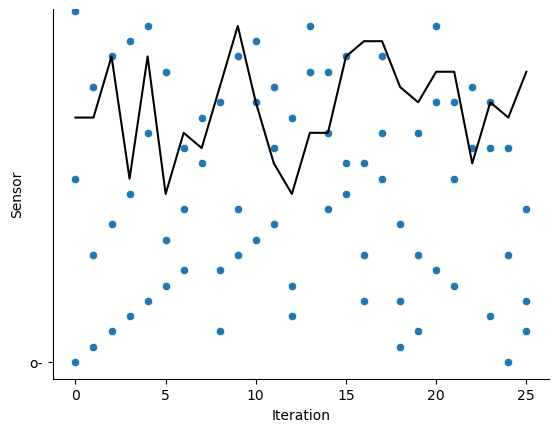

In [69]:
x, y = [], []
for i in range(len(guesses)):
    for j in range(len(guesses[i])):
        x.append(i)
        y.append(guesses[i][j])
df = pd.DataFrame({'Iteration':x, 'Sensor':y})
sns.scatterplot(data=df,
                x='Iteration',
                y='Sensor')
plt.plot(np.arange(0, len(scores)), scores, 'k', 'o-')
sns.despine()


### Greedy Algorithm

In [18]:
n

10

In [10]:
bot = brad.chatbot(interactive=False, config='/home/jpic/RAG-DEV/tutorials/control/config-no-debug.json')

Enter your NVIDIA API key:  ········


2024-08-01 10:02:03 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-08-01_10-01-51/log.json. How can I help?


In [26]:
history = ""
first_template = """You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size {n} by {n}. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the ith column of C. You may select {p} state
variables, numbered 0, 1, ..., {n}-1 to measure.

**Strategy**
Deploy the following strategy to select your sensors: GREEDY ALGORITHM. In this round, choose a single
starting sensors $i$, and the rank of the observability matrix will be reported. Then, in subsequent rounds
choose sensor sets that include $i$ and one other sensor at a time. Based on testing $i$ with each other sensor
and the ranks of the observablity matrix, in a final step, you will select the next best vertex to add. We will
then repeat this process until the rank stops increasing.

Given this strategy, you must propose the single initial sensor to start with. This will initialize the checking
and rest of the proceedure. Your response will be parsed by software, so it must conform to our output structure.
Pleased do not provide any additional output, or explination at this time. 

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
"""

second_template = """You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

**Strategy**
Deploy the following strategy to select your sensors: GREEDY ALGORITHM. In this round, use the history to deteremine
which sensor variable needs to be checked at this stage of the Greedy Algorithm. Use the histroy to find
which variable we know to keep, and then try one new sensor variable $j$. Based on the variables you would
like to keep from previous points in the algorithm and $j$ propose a new set of sensors.

Greedy algorithm:
While not meeting stopping condition:
    (CHECK) test all remaining sensors individually
    (SELECT) choose the best sensor

Example 1
```
    A is 8 by 8
    Iteration=2
    History:
    Sensors=[0] Kalman Rank=2
    Sensors=[0,1] Kalman Rank=3
    Sensors=[0,2] Kalman Rank=2
    Sensors=[0,3] Kalman Rank=2
New sensors:
Sensors=1,4
```
Explanation: At iteration 2, sensor 0 is kept fixed, and sensor 1 has been tested with sensors 2 and 3.
Now we test sensor 4 with 0 and 1.

Example 2
```
    A is 5 by 5
    Iteration=2
    History:
    Sensors=[0 Kalman Rank=2
    Sensors=[0,1] Kalman Rank=3
    Sensors=[0,2] Kalman Rank=2
    Sensors=[0,3] Kalman Rank=2
    Sensors=[0,4] Kalman Rank=4
New sensors:
Sensors=0,4,1
```
Explanation: At iteration 3, we keep sensors 0 and 1 fixed. Sensor 4 has been tested with 0 and 1 and
yielded the highest rank. So, we select sensor 4 and proceed to test new combinations.

Example 3
```
    A is 12 by 12
    Iteration=2
    History:
    Sensors=[0] Kalman Rank=2
    Sensors=[0,1] Kalman Rank=3
New sensors:
Sensors=0,1
```
Explanation: This example is NOT correct. Do NOT follow this example. This example makes
the mistake of retesting sensors that have already been checked together. At iteration 2,
sensor 0 is fixed, and sensor 1 has already been tested. Here the combination [0,1] is incorrectly
checked a second time.

**Known Results**
Here is a history of sensor sets that have been tested and the associated Kalman Rank:
{history}

Current Iteration={round}

**Instructions:
- Use the Known R, the strategy, and examples above to propose a new sensor set.
- Do not propose a sensor set that is above in the Known Results.
- Increase the size of the sensor set by one element during the SELECT stage.
- Use the below output format
- Do not include additional information in your output

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
Reasoning=<explain what in the history motivated testing this combination of sensors. 3 Sentences only>
Stage=<CHECK, or SELECT>
"""

filled_template = first_template.format(n=n, p=p)
response = bot.invoke(filled_template)
score = 0
guesses = []
scores  = []
while score < n:
    idxs = responseParser(response)
    guesses.append(idxs)
    C = generate_brad_C(n, idxs)
    O = compute_observability_matrix(A, C)
    score = score_observability(O)
    scores.append(score)
    print("*********************")
    print(f"{score=}")
    print("*********************")
    if score == n:
        break
    
    history += f'\nSensors={idxs}, Kalman Rank={score}'
    
    filled_template = second_template.format(idxs=str(idxs), score=score, p=p, history=history, n=n, round=len(idxs))
    response = bot.invoke(filled_template)
    if len(scores) > 25:
        break
    

2024-08-01 10:34:40,334 - INFO - RAG


BRAD >> 162: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 10 by 10. You must select which state variables to
measure. If variable i is measured, then there will be a

2024-08-01 10:34:40,684 - INFO - 


route



2024-08-01 10:34:40,684 - INFO - RAG
2024-08-01 10:34:40,684 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=0
*********************
score=5
*********************


2024-08-01 10:34:41,634 - INFO - RAG


BRAD >> 163: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

**Strategy**
Deploy the following strategy to select your sensors: GREEDY ALGORITHM. In this round, use the history to deteremine
which sensor variable needs to b

2024-08-01 10:34:42,710 - INFO - 


route



2024-08-01 10:34:42,710 - INFO - RAG
2024-08-01 10:34:42,710 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 1]
Reasoning=Sensor 0 is kept fixed from the Known Results. Sensor 1 is tested as it is a new sensor variable that has not been checked with 0. This combination has not been tested before and may increase the Kalman Rank.
Stage=SELECT
*********************
score=5
*********************
BRAD >> 164: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: 

2024-08-01 10:34:43,902 - INFO - 


route



2024-08-01 10:34:43,903 - INFO - RAG
2024-08-01 10:34:43,903 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2]
Reasoning=Sensor 0 is kept fixed, and sensor 1 has already been tested. We test sensor 2 with 0 to see if it improves the Kalman Rank. Sensor 2 has not been tested with 0 yet, so this combination is worth exploring.
Stage=SELECT
*********************
score=7
*********************


2024-08-01 10:34:44,107 - INFO - RAG


BRAD >> 165: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

**Strategy**
Deploy the following strategy to select your sensors: GREEDY ALGORITHM. In this round, use the history to deteremine
which sensor variable needs to b

2024-08-01 10:34:45,384 - INFO - 


route



2024-08-01 10:34:45,384 - INFO - RAG
2024-08-01 10:34:45,384 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 1, 2]
Reasoning=We keep sensor 0 fixed, as it's the initial sensor, and sensor 1 has been tested with 0. Sensor 2 has not been tested with 0 and 1 together, and it's the best option to increase the Kalman Rank. This combination has not been tested before.
Stage=SELECT
*********************
score=7
*********************
BRAD >> 166: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to t

2024-08-01 10:34:46,837 - INFO - 


route



2024-08-01 10:34:46,837 - INFO - RAG
2024-08-01 10:34:46,837 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 1]
Reasoning=At iteration 3, I kept sensor 0 and 2 fixed, which yielded the highest Kalman Rank of 7. I then tested sensor 1 with 0 and 2, which also yielded a Kalman Rank of 7. This combination was not previously tested, and including sensor 1 may further improve the observability.
Stage=SELECT
*********************
score=7
*********************
BRAD >> 167: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answ

2024-08-01 10:34:48,176 - INFO - 


route



2024-08-01 10:34:48,176 - INFO - RAG
2024-08-01 10:34:48,177 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 1]
Reasoning=At iteration 3, I kept sensor 0 and 2 fixed, which yielded a Kalman Rank of 7. Sensor 1 has been tested with 0, but not with 0 and 2. So, I propose testing sensor 1 with 0 and 2.
Stage=SELECT
*********************
score=7
*********************


2024-08-01 10:34:48,708 - INFO - RAG


BRAD >> 168: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

**Strategy**
Deploy the following strategy to select your sensors: GREEDY ALGORITHM. In this round, use the history to deteremine
which sensor variable needs to b

2024-08-01 10:34:50,081 - INFO - 


route



2024-08-01 10:34:50,082 - INFO - RAG
2024-08-01 10:34:50,082 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3]
Reasoning=We keep sensors 0 and 2 fixed because they yielded the highest Kalman Rank of 7 when combined. Sensor 3 was not tested with sensor 2, so we try this new combination. This combination is also motivated by the fact that sensor 3 was not tested with the best previous combination [0, 2].
Stage=SELECT
*********************
score=9
*********************
BRAD >> 169: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own code

2024-08-01 10:34:51,692 - INFO - 


route



2024-08-01 10:34:51,693 - INFO - RAG
2024-08-01 10:34:51,693 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 1]
Reasoning=At iteration 3, sensor 0 and sensor 2 have already been tested together, yielding a high Kalman Rank of 7. Sensor 1 has also been tested with sensor 0, resulting in a Kalman Rank of 5. This new combination of sensors 0, 2, and 1 is proposed to explore the potential of increasing the Kalman Rank further.
Stage=SELECT
*********************
score=7
*********************
BRAD >> 170: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or ana

2024-08-01 10:34:53,322 - INFO - 


route



2024-08-01 10:34:53,322 - INFO - RAG
2024-08-01 10:34:53,323 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 4]
Reasoning=At iteration 3, I kept sensor 0 and 2 fixed, and sensor 4 has not been tested with 0 and 2 yet. The highest Kalman Rank achieved so far is 9 with sensors 0, 2, and 3, but I want to explore other possibilities. I choose sensor 4 to test because it has not been combined with 0 and 2 yet.
Stage=SELECT
*********************
score=7
*********************
BRAD >> 171: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own co

2024-08-01 10:34:54,848 - INFO - 


route



2024-08-01 10:34:54,848 - INFO - RAG
2024-08-01 10:34:54,849 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3]
Reasoning=At iteration 3, I kept sensor 0 and 2 fixed, which yielded a Kalman Rank of 7. Sensor 3 was tested with sensors 0 and 2, resulting in a higher Kalman Rank of 9. I am selecting sensor 3 to combine with 0 and 2.
Stage=SELECT
*********************
score=9
*********************
BRAD >> 172: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prom

2024-08-01 10:34:56,217 - INFO - 


route



2024-08-01 10:34:56,217 - INFO - RAG
2024-08-01 10:34:56,218 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3, 4]
Reasoning=At iteration 3, sensors [0, 2, 3] have the highest Kalman Rank of 9. Sensor 4 has not been tested with this combination, so it's a good candidate to increase the rank. Adding sensor 4 to the set may improve observability.
Stage=SELECT
*********************
score=9
*********************
BRAD >> 173: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your

2024-08-01 10:34:57,993 - INFO - 


route



2024-08-01 10:34:57,993 - INFO - RAG
2024-08-01 10:34:57,994 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3, 4]
Reasoning=At iteration 4, we keep sensors 0, 2, and 3 fixed, and sensor 4 has not been tested with this combination. The highest Kalman Rank was obtained with sensors [0, 2, 3] and [0, 2, 3, 4] is a natural extension. This new combination is likely to increase the Kalman Rank.
Stage=SELECT
*********************
score=9
*********************
BRAD >> 174: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answ

2024-08-01 10:34:59,365 - INFO - 


route



2024-08-01 10:34:59,365 - INFO - RAG
2024-08-01 10:34:59,366 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3, 1]
Reasoning=The combination of sensors [0, 2, 3] has the highest Kalman Rank of 9. Sensor 1 has not been tested with this combination before. It is reasonable to test sensor 1 with the existing set of sensors that have yielded the highest rank so far.
Stage=SELECT
*********************
score=9
*********************
BRAD >> 175: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions t

2024-08-01 10:35:01,267 - INFO - 


route



2024-08-01 10:35:01,268 - INFO - RAG
2024-08-01 10:35:01,268 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3, 4]
Reasoning=In the previous iterations, the sets [0, 2, 3] and [0, 2, 3, 4] both achieved a Kalman Rank of 9. Since we're looking to increase the sensor set size by one, we add sensor 4 to the existing set [0, 2, 3] to potentially improve the observability. This new combination is motivated by the high ranks achieved in the previous iterations with similar sensor sets.
Stage=SELECT
*********************
score=9
*********************
BRAD >> 176: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics

2024-08-01 10:35:02,799 - INFO - 


route



2024-08-01 10:35:02,800 - INFO - RAG
2024-08-01 10:35:02,800 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3, 4]
Reasoning=Sensor 4 was selected in the previous iteration, and we are adding a new sensor to the set. Sensor 1 has not been tested with sensors 0, 2, and 3, so it's a good candidate to try. The history suggests that adding sensor 1 to the set may increase the Kalman Rank.
Stage=SELECT
*********************
score=9
*********************
BRAD >> 177: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer th

2024-08-01 10:35:04,331 - INFO - 


route



2024-08-01 10:35:04,331 - INFO - RAG
2024-08-01 10:35:04,332 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=[0, 2, 3, 5]
Reasoning=Based on the history, sensor 0 and 2 have been tested together, and adding sensor 3 resulted in a higher Kalman rank. Sensor 5 has not been tested with this combination, and we want to explore its impact on the observability. We are increasing the sensor set size by one element during the SELECT stage.
Stage=SELECT
*********************
score=10
*********************


### Digital Lab (many BOTs)

In [64]:
indika = brad.chatbot(interactive=False, config='/home/jpic/RAG-DEV/tutorials/control/config-no-debug.json')
joshua = brad.chatbot(interactive=False, config='/home/jpic/RAG-DEV/tutorials/control/config-no-debug.json')
cooper = brad.chatbot(interactive=False, config='/home/jpic/RAG-DEV/tutorials/control/config-no-debug.json')

2024-08-01 03:35:07 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-08-01_03-35-06/log.json. How can I help?


2024-08-01 03:35:18 INFO semantic_router.utils.logger local
2024-08-01 03:35:22 INFO semantic_router.utils.logger local


Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-08-01_03-35-17/log.json. How can I help?
Welcome to RAG! The chat log from this conversation will be saved to /home/jpic/BRAD/2024-08-01_03-35-22/log.json. How can I help?


In [76]:
response = indika.invoke("""You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size {n} by {n}. The matrix C can be {p} by {n}. You must 
select which state variables to measure. If variable i is measured, then there will be a 1 in the ith column
of C. You may select {p} state variables, numbered 0, 1, ..., {n}-1 to measure.

The matrix A is = {A}

To find the optimal sensors, you can give instructions to two chatbots. Each bot is capable of proposing
sensor combinations of between 1 and {p} sensors, and then the bots will veryify the Kalman Rank of the
system with those propose sensors.

Please explain the problem to the chatbots, and design a strategy to instruct each bot or agent
how you would like them to try and identify the sensors. You can allow them to make between 1 and 5 attempts
at selecting sensors each before reporting their findings back.""".format(n=n, p=p, A=A))

2024-08-01 03:44:44,123 - INFO - RAG


BRAD >> 1: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 25 by 25. The matrix C can be 3 by 25. You must 
select which state variables to measure. If variable i is me

2024-08-01 03:44:52,455 - INFO - 


route



2024-08-01 03:44:52,455 - INFO - RAG
2024-08-01 03:44:52,456 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Let's explain the problem to the chatbots and design a strategy for them to identify the optimal sensors.

**Problem Explanation:**

We have a system described by the equation dx/dt = Ax, where A is a 25x25 sparse matrix. We want to measure the system using y = Cx, where C is a 3x25 matrix. Our goal is to select 3 state variables to measure, which means we need to choose 3 columns of C that will provide the best observability of the system. The observability of the system is determined by the Kalman observability matrix, which is constructed by stacking the matrices C^T, C^TA, C^TA^2, and so on.

**Strategy:**

We will instruct each chatbot to propose sensor combinations and verify the Kalman rank of the system with those proposed sensors. We will allow each bot to make up to 5 attempts at selecting sensors before reporting their findings.

**Bot 1: Random Search**

1. Instruct Bot 1 to randomly select 3 columns of C for its first attempt.
2. Calculate the Kalman obs

### Walk Through

In [58]:
first_template = """You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size {n} by {n}. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the ith column of C. You may select {p} state
variables, numbered 0, 1, ..., n-1 to measure.

Based on the sensors you select, the rank of the Kalman observability matrix will be provided for the set of
sensors you select. We will then try a new set of sensors until the rank of the Kalman matrix is n.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
"""

In [59]:
filled_template = template.format(n=n, p=p)
print(filled_template)

You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 5 by 5. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the ith column of C. You may select 2 state
variables, numbered 0, 1, ..., n-1 to measure.

Based on the sensors you select, the rank of the Kalman observability matrix will be provided for the set of
sensors you select. We will then try a new set of sensors until the rank of the Kalman matrix is n.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor 2>



In [60]:
response = bot.invoke(filled_template)

2024-08-01 02:44:53,745 - INFO - RAG


BRAD >> 0: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: 


New Input: 
Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 5 by 5. You must select which state variables to
measure. If variable i is measured, then there will be a 1 i

2024-08-01 02:44:55,234 - INFO - 


route



2024-08-01 02:44:55,235 - INFO - RAG
2024-08-01 02:44:55,235 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=


> Finished chain.
Sensors=0,1


In [72]:
history = ""

In [73]:
idxs = responseParser(response)
C = generate_brad_C(n, idxs)
O = compute_observability_matrix(A, C)
score = score_observability(O)
history += f'Sensors={idxs}, Kalman Rank={score}'

second_template = """Based on your previous proposals, we have the following results:
{history}

Given this information, please propose new sensors to maximize the Kalman Rank.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
"""

filled_template = second_template.format(idxs=str(idxs), score=score, p=p, history=history)
print(filled_template)

Based on your previous proposals, we have the following results:
Sensors=[0, 1], Kalman Rank=2

Given this information, please propose new sensors to maximize the Kalman Rank.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor 2>



In [74]:
response = bot.invoke(filled_template)

2024-08-01 02:51:25,219 - INFO - RAG


BRAD >> 1: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: Human: Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 5 by 5. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the it

2024-08-01 02:51:25,583 - INFO - 


route



2024-08-01 02:51:25,583 - INFO - RAG
2024-08-01 02:51:25,583 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: Based on your previous proposals, we have the following results:\nSensors=[0, 1],


> Finished chain.
Sensors=2,3


In [77]:
idxs = responseParser(response)
C = generate_brad_C(n, idxs)
O = compute_observability_matrix(A, C)
score = score_observability(O)
history += f'\nSensors={idxs}, Kalman Rank={score}'

second_template = """Based on your previous proposals, we have the following results:
{history}

Given this information, please propose new sensors to maximize the Kalman Rank.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor {p}>
"""

filled_template = second_template.format(idxs=str(idxs), score=score, p=p, history=history)
print(filled_template)

Based on your previous proposals, we have the following results:
Sensors=[0, 1], Kalman Rank=2
Sensors=[2, 3], Kalman Rank=2

Given this information, please propose new sensors to maximize the Kalman Rank.

Please provide your output in the format of a comma separated list, and do not add additional output.

**Output Format**
Sensors=<sensor 1, ..., sensor 2>



In [78]:
response = bot.invoke(filled_template)

2024-08-01 02:52:33,835 - INFO - RAG


BRAD >> 2: 


> Entering new ConversationChain chain...
Prompt after formatting:
Current conversation: Human: Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,
bioinformatics, genetics, and data science. You can be connected to a text database to augment your answers
based on the literature with Retrieval Augmented Generation, or you can use several additional modules including
searching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake
and matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your
ability.

Prompt: You are in charge of optimal sensor placement. We are studying the system: dx/dt=Ax and y=Cx

The Kalman observability matrix is [C^T; C^TA; C^TA^2; ... ]

The matrix A is known and A is a sparse matrix of size 5 by 5. You must select which state variables to
measure. If variable i is measured, then there will be a 1 in the it

2024-08-01 02:52:34,195 - INFO - 


route



2024-08-01 02:52:34,195 - INFO - RAG
2024-08-01 02:52:34,195 - INFO - 

PLANNER:

{'module': 'RAG', 'steps': [{'llm': "model='meta/llama3-70b-instruct'", 'memory': 'None', 'prompt': "input_variables=['history', 'input'] template='Current conversation: {history}\\n\\n\\nNew Input: \\n{input}'", 'input': 'Context: You are BRAD (Bioinformatic Retrieval Augmented Data), a chatbot specializing in biology,\nbioinformatics, genetics, and data science. You can be connected to a text database to augment your answers\nbased on the literature with Retrieval Augmented Generation, or you can use several additional modules including\nsearching the web for new articles, searching Gene Ontology or Enrichr bioinformatics databases, running snakemake\nand matlab pipelines, or analyzing your own codes. Please answer the following questions to the best of your\nability.\n\nPrompt: Based on your previous proposals, we have the following results:\nSensors=[0, 1],


> Finished chain.
Sensors=0,4


In [ ]:
# Define the system matrix A
n = 5
p = 2
sparsity = 0.9
A = generate_random_sparse_matrix(n, sparsity)

# Parameters for iteration
num_iterations = 3
best_C = None
best_score = 0

for _ in range(num_iterations):
    # Guess matrix C
    C = generate_random_binary_C(p, n)
    
    # Compute observability matrix
    O = compute_observability_matrix(A, C)
    
    # Score the observability
    score = score_observability(O)
    
    print(f"Matrix C:\n{C}\nObservability Matrix:\n{O}\nScore: {score}\n")
    
    # Update the best C if current score is higher
    if score > best_score:
        best_score = score
        best_C = C

print(f"Best Matrix C:\n{best_C}\nBest Score: {best_score}")

In [27]:
import scanpy as sc

In [38]:
adata = sc.read_h5ad('/nfs/turbo/umms-indikar/shared/projects/geneformer/fib15k/jpic/cluster_centroids.h5ad')

In [39]:
adata.shape

(6325, 512)

In [40]:
adata.obs

,recipe,filename,batch
0,FOS;STAT5A;FOSB;IKZF1;ETV6,2024-07-31_12-44-38_job_number_209.h5ad,0
1,FOS;STAT5A;FOSB;IKZF1;ETV6,2024-07-31_12-44-38_job_number_209.h5ad,0
2,FOS;STAT5A;FOSB;IKZF1;ETV6,2024-07-31_12-44-38_job_number_209.h5ad,0
3,FOS;STAT5A;FOSB;IKZF1;ETV6,2024-07-31_12-44-38_job_number_209.h5ad,0
4,FOS;STAT5A;FOSB;IKZF1;ETV6,2024-07-31_12-44-38_job_number_209.h5ad,0
...,...,...,...
20,GFI1B;FOS;REL;IKZF1;RUNX3,2024-07-31_10-13-03_job_number_146.h5ad,1
21,GFI1B;FOS;REL;IKZF1;RUNX3,2024-07-31_10-13-03_job_number_146.h5ad,1
22,GFI1B;FOS;REL;IKZF1;RUNX3,2024-07-31_10-13-03_job_number_146.h5ad,1
23,GFI1B;FOS;REL;IKZF1;RUNX3,2024-07-31_10-13-03_job_number_146.h5ad,1
